In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
import warnings

plt.style.use("ggplot")
warnings.filterwarnings('ignore')

### Load Training Data

In [2]:
# train = pd.read_csv('librosa_train.csv', index_col=0)
import feather  # Super fast way to read/write tabular data
training_data = feather.read_dataframe('librosa_train.feather').set_index('index')

In [3]:
training_data.head()

,0,1,2,3,4,5,6,7,8,9,...,110242,110243,110244,110245,110246,110247,110248,110249,label,manually_verified
index,,,,,,,,,,,,,,,,,,,,,
00044347.wav,0.000196,0.000184,-0.000558,-0.000475,-0.000197,0.002283,0.005400,0.004636,0.002014,-0.001139,...,0.004421,-0.000158,-0.001225,-0.001405,-0.002914,-0.002054,0.001746,0.005911,Hi-hat,0
001ca53d.wav,-0.000137,-0.000134,-0.000180,-0.000302,-0.000316,-0.000354,-0.000288,-0.000218,-0.000153,-0.000129,...,-0.047156,-0.042922,-0.038064,-0.032372,-0.026851,-0.019539,-0.011830,-0.004523,Saxophone,1
003b91e8.wav,0.003192,0.004887,0.004513,0.004942,0.004590,0.004805,0.004618,0.004490,0.004210,0.003965,...,-0.118151,-0.121667,-0.124016,-0.124748,-0.124058,-0.122464,-0.119517,-0.115610,Cello,0
004ad66f.wav,0.000304,0.000175,0.000230,0.000544,0.000952,0.000992,0.000496,-0.000109,-0.000381,-0.000050,...,-0.017168,0.008772,0.025181,0.019667,0.006811,0.001818,-0.005867,-0.025309,Clarinet,0
0063ab88.wav,-0.000331,-0.000207,-0.000366,-0.000541,-0.000449,-0.000410,-0.000546,-0.000444,-0.000472,-0.000267,...,0.001698,0.003014,0.000692,0.000739,0.000644,0.001278,0.003317,0.000078,Computer_keyboard,0


## MODEL

In [4]:
from collections import namedtuple
TrainingResults = namedtuple('TraingResults', ['qw', 'qz', 'w_mean', 'w_stddev', 'z_mean', 'z_stddev', 'generated_x_samples'])

In [5]:
def train_ppca(x_train, data_dim, latent_dim, num_datapoints, stddv_datapoints):
    def probabilistic_pca(data_dim, latent_dim, num_datapoints, stddv_datapoints): # (unmodeled) data
        w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                    scale=2.0 * tf.ones([data_dim, latent_dim]),
                    name="w")  # PRINCIPAL COMPONENTS
        z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
                    scale=tf.ones([latent_dim, num_datapoints]), 
                    name="z")  # LATENT VARIABLE (LOCAL TO EACH DATA POINT)
        x = ed.Normal(loc=tf.matmul(w, z),
                    scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
                    name="x")  # (modeled) data
        return x, (w, z)

    log_joint = ed.make_log_joint_fn(probabilistic_pca)
    
    def target(w, z):
        """Unnormalized target density as a function of the parameters."""
        return log_joint(data_dim=data_dim,
                       latent_dim=latent_dim,
                       num_datapoints=num_datapoints,
                       stddv_datapoints=stddv_datapoints,
                       w=w, z=z, x=x_train)
    
    tf.reset_default_graph()

    def variational_model(qw_mean, qw_stddv, qz_mean, qz_stddv):
      qw = ed.Normal(loc=qw_mean, scale=qw_stddv, name="qw")
      qz = ed.Normal(loc=qz_mean, scale=qz_stddv, name="qz")
      return qw, qz


    log_q = ed.make_log_joint_fn(variational_model)

    def target_q(qw, qz):
      return log_q(qw_mean=qw_mean, qw_stddv=qw_stddv,
                   qz_mean=qz_mean, qz_stddv=qz_stddv,
                   qw=qw, qz=qz)


    qw_mean = tf.Variable(np.ones([data_dim, latent_dim]), dtype=tf.float32)
    qz_mean = tf.Variable(np.ones([latent_dim, num_datapoints]), dtype=tf.float32)
    qw_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([data_dim, latent_dim]), dtype=tf.float32))
    qz_stddv = tf.nn.softplus(tf.Variable(-4 * np.ones([latent_dim, num_datapoints]), dtype=tf.float32))

    qw, qz = variational_model(qw_mean=qw_mean, qw_stddv=qw_stddv,
                               qz_mean=qz_mean, qz_stddv=qz_stddv)

    energy = target(qw, qz)
    entropy = -target_q(qw, qz)

    elbo = energy + entropy


    optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
    train = optimizer.minimize(-elbo)

    init = tf.global_variables_initializer()

    t = []

    num_epochs = 100

    with tf.Session() as sess:
      sess.run(init)

      for i in range(num_epochs):
        sess.run(train)
        if i % 5 == 0:
          t.append(sess.run([elbo]))

      w_mean_inferred = sess.run(qw_mean)
      w_stddv_inferred = sess.run(qw_stddv)
      z_mean_inferred = sess.run(qz_mean)
      z_stddv_inferred = sess.run(qz_stddv)
    
    plt.plot(range(1, num_epochs, 5), t)
    plt.show()
    
    def replace_latents(w=None, z=None):
        """
        Helper function that replaces our prior for w and z with the mean that we estimated through VI
        """

        def interceptor(rv_constructor, *rv_args, **rv_kwargs):
            """Replaces the priors with actual values to generate samples from."""
            name = rv_kwargs.pop("name")
            if name == "w":
              rv_kwargs["value"] = w
            elif name == "z":
              rv_kwargs["value"] = z
            return rv_constructor(*rv_args, **rv_kwargs)

        return interceptor
    
    
    with ed.interception(replace_latents(w_mean_inferred, z_mean_inferred)):
      generate = probabilistic_pca(
          data_dim=data_dim, latent_dim=latent_dim,
          num_datapoints=num_datapoints, stddv_datapoints=stddv_datapoints)

    with tf.Session() as sess:
      x_generated, _ = sess.run(generate)
    
    return TrainingResults(qw, qz, w_mean_inferred, w_stddv_inferred, z_mean_inferred, z_stddv_inferred, x_generated)

## TRAIN MODELS

Training PPCA for label: Hi-hat


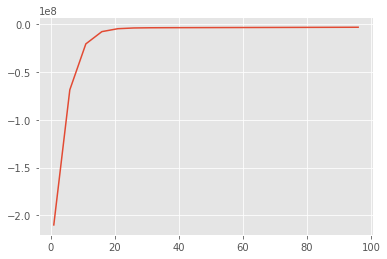

Training PPCA for label: Saxophone


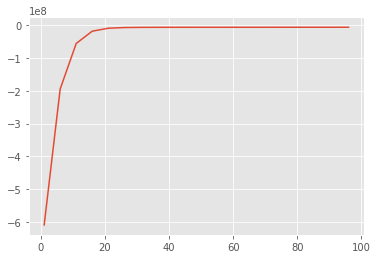

Training PPCA for label: Cello


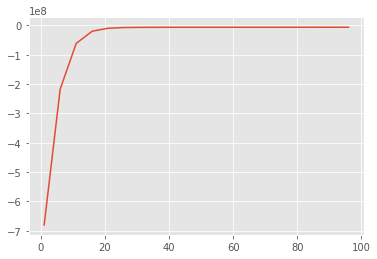

Training PPCA for label: Clarinet


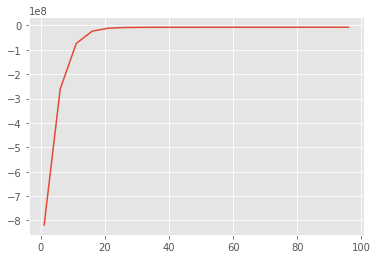

Training PPCA for label: Computer_keyboard


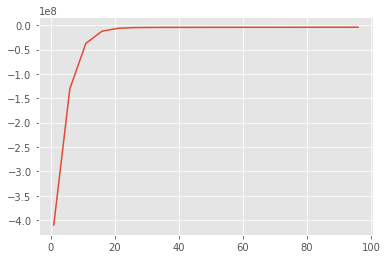

Training PPCA for label: Keys_jangling


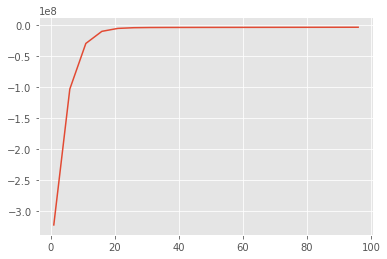

Training PPCA for label: Tearing


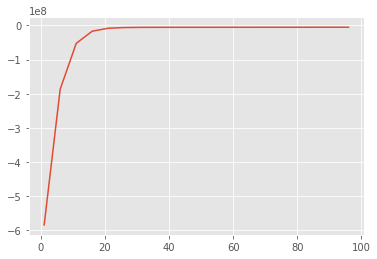

Training PPCA for label: Flute


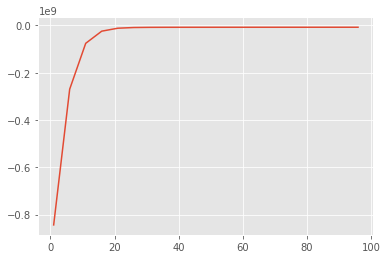

Training PPCA for label: Telephone


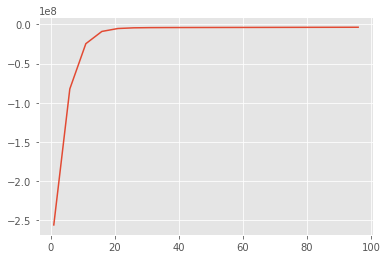

Training PPCA for label: Bark


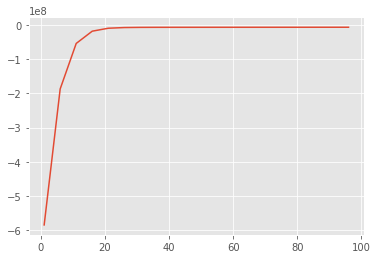

Training PPCA for label: Chime


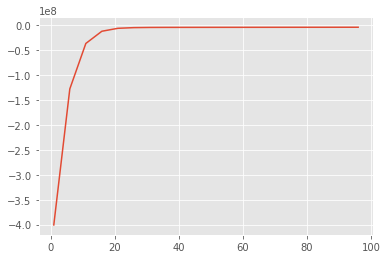

Training PPCA for label: Bus


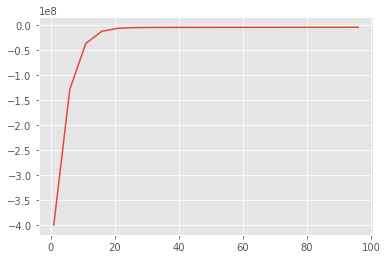

Training PPCA for label: Squeak


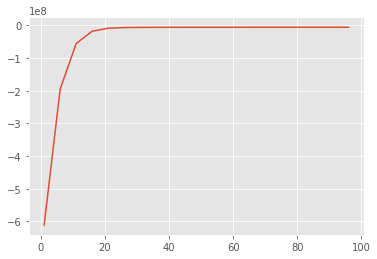

Training PPCA for label: Scissors


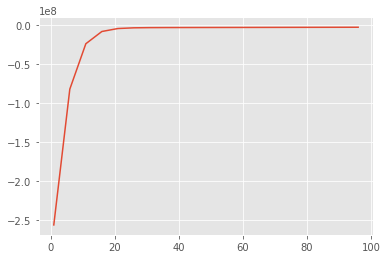

Training PPCA for label: Harmonica


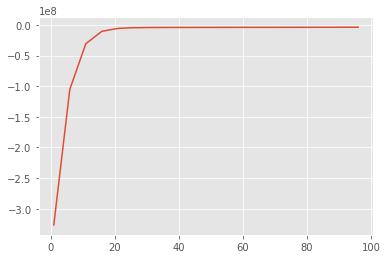

Training PPCA for label: Gong


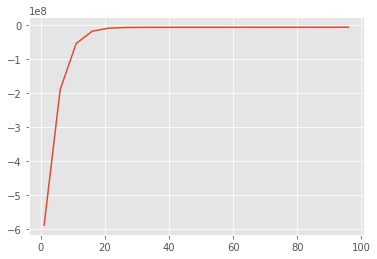

Training PPCA for label: Fireworks


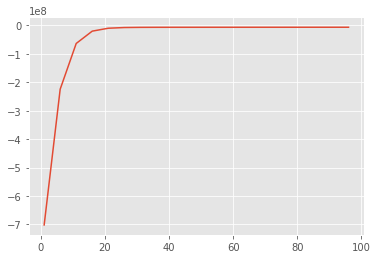

Training PPCA for label: Writing


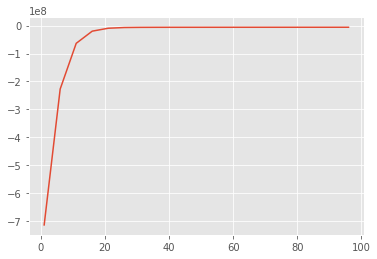

Training PPCA for label: Gunshot_or_gunfire


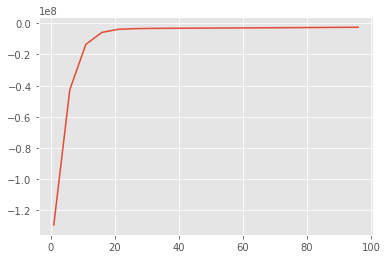

Training PPCA for label: Fart


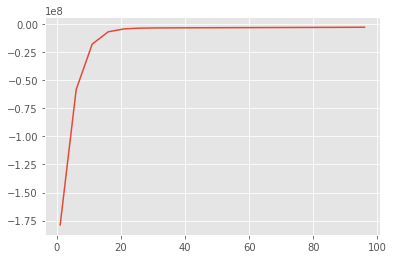

Training PPCA for label: Double_bass


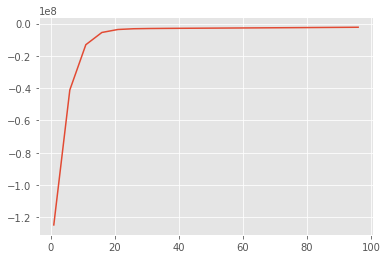

Training PPCA for label: Microwave_oven


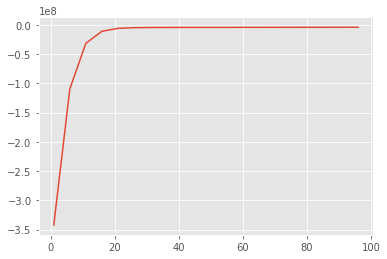

Training PPCA for label: Electric_piano


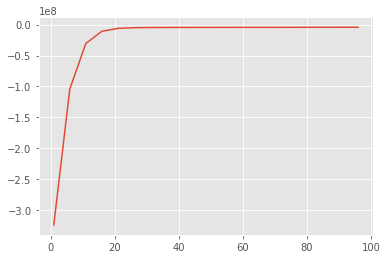

Training PPCA for label: Applause


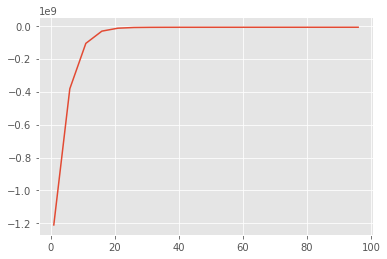

Training PPCA for label: Acoustic_guitar


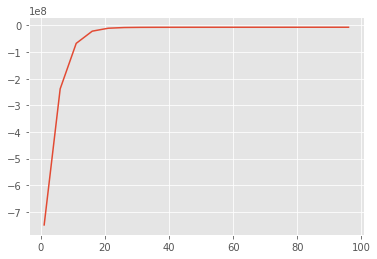

Training PPCA for label: Knock


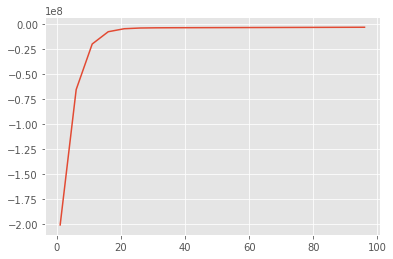

Training PPCA for label: Drawer_open_or_close


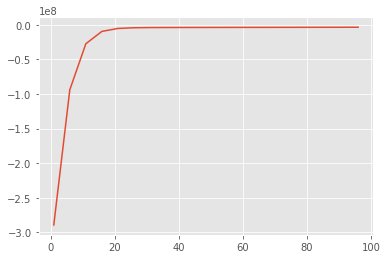

Training PPCA for label: Laughter


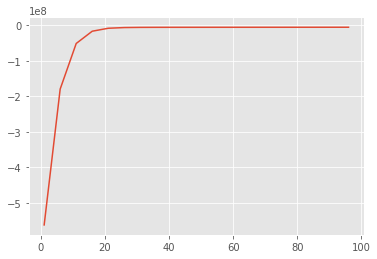

Training PPCA for label: Violin_or_fiddle


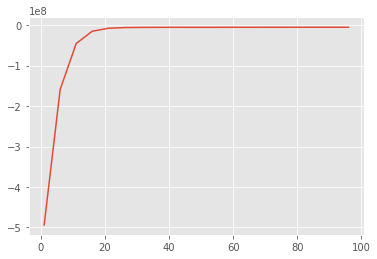

Training PPCA for label: Trumpet


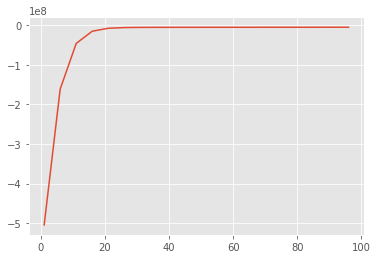

Training PPCA for label: Cough


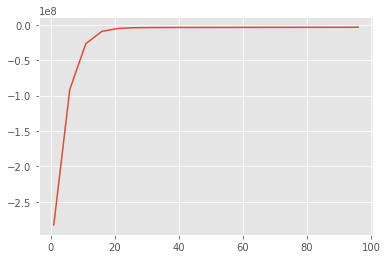

Training PPCA for label: Bass_drum


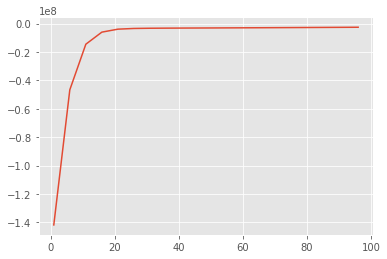

Training PPCA for label: Oboe


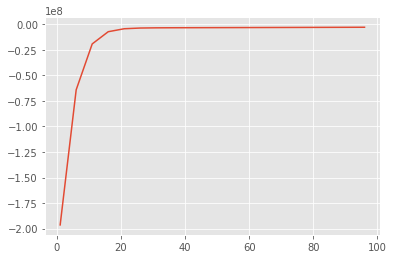

Training PPCA for label: Finger_snapping


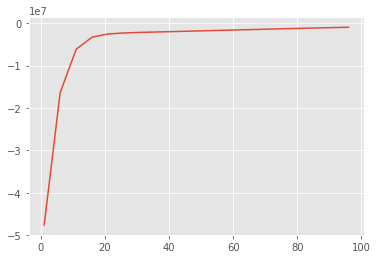

Training PPCA for label: Tambourine


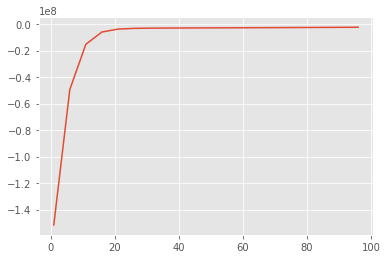

Training PPCA for label: Snare_drum


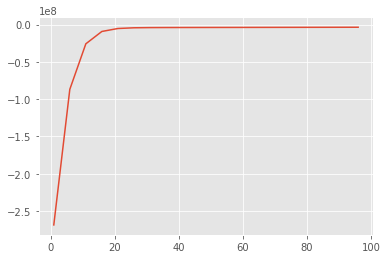

Training PPCA for label: Meow


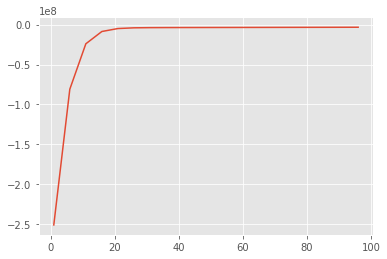

Training PPCA for label: Cowbell


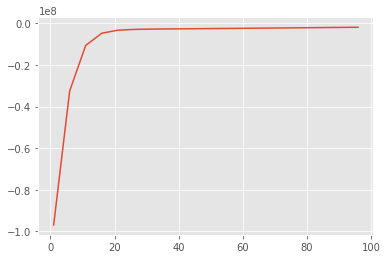

Training PPCA for label: Burping_or_eructation


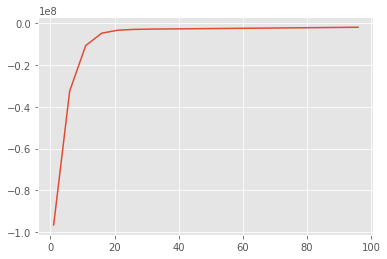

Training PPCA for label: Shatter


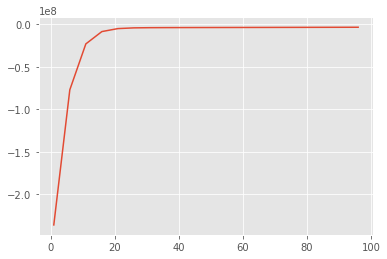

Training PPCA for label: Glockenspiel


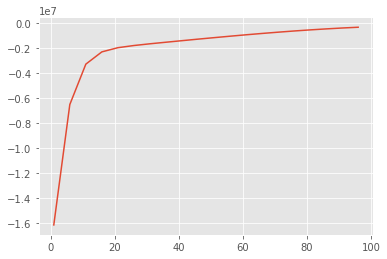

In [20]:
training_results = []
for label in training_data['label'].unique():
    print("Training PPCA for label: {}".format(label))
    train_label = training_data.loc[training_data['label']==label].copy()
    Y_train_label = train_label.pop('label')
    train_label.pop('manually_verified')
    x_train = train_label

    
    latent_dim = 5  # ARBITRAY, WE SHOULD TUNE THIS
    stddv_datapoints = 0.5  # I think we can also treat sigma as a RV, but we are currently only treating W and z as RV's
    x_train = x_train.transpose().values  # This is kind of weird, but the shape is expected to be DATA_DIM X NUM_DATAPOINTS
    data_dim = x_train.shape[0]
    num_datapoints = x_train.shape[1]
    
    training_result = train_ppca(x_train, data_dim, latent_dim, num_datapoints, stddv_datapoints)
    training_results.append((label, training_result))

## OUTPUT SAMPLE WAV FILES

In [23]:
import os
import librosa
import random

In [26]:
for label, training_result in training_results:
    generated_samples = training_result.generated_x_samples
    generated_samples = generated_samples.transpose()  # Back into regular format
    rand = random.randint(0, generated_samples.shape[0]-1)
    if not os.path.isdir('generated_samples'):
        os.mkdir('generated_samples')
    librosa.output.write_wav('generated_samples/{}_generated_sample.wav'.format(label), generated_samples[rand], 22050)

## (Work In Progress) Getting posterior predictive distribution 

In [27]:
tfd = tfp.distributions

In [28]:
w = ed.Normal(loc=tf.zeros([data_dim, latent_dim]),
                    scale=2.0 * tf.ones([data_dim, latent_dim]),
                    name="w")  # PRINCIPAL COMPONENTS
z = ed.Normal(loc=tf.zeros([latent_dim, num_datapoints]),
            scale=tf.ones([latent_dim, num_datapoints]), 
            name="z")  # LATENT VARIABLE (LOCAL TO EACH DATA POINT)
x = ed.Normal(loc=tf.matmul(w, z),
            scale=stddv_datapoints * tf.ones([data_dim, num_datapoints]),
            name="x")  # (modeled) data

In [29]:
training_result.qw.shape[0]

Dimension(110250)

In [30]:
training_result.qz.shape[1]

Dimension(3)

In [31]:
# not correct
x_post = tfd.Normal(
    loc=tf.matmul(training_result.qw, training_result.qz), 
    scale=tf.ones([training_result.qw.shape[0], training_result.qz.shape[1]]),
    name="x_post"
)

In [32]:
x_post = tfd.Normal(
    loc=tf.matmul(training_result.w_mean, training_result.z_mean),
    scale=stddv_datapoints * tf.ones([training_result.w_mean.shape[0], training_result.z_mean.shape[1]]),
    name="x_post"
)

In [15]:
x_post

<tfp.distributions.Normal 'x_post_1/' batch_shape=(110250, 46) event_shape=() dtype=float32>

^ It's weird that the Normal distribution has the number of samples baked in; it's because each sample has it's own latent variable z_i that we estimated. For prediction, we need to marginalize out the latent variables...

In [16]:
with tf.Session() as sess:
    s = x_post.sample().eval(session=sess)
    # l = x_post.log_prob(x_train).eval()

In [17]:
s.shape

(110250, 46)

^ Sampling generates 46 new samples (the same as our training size)

In [18]:
x_post.log_prob

<bound method Distribution.log_prob of <tfp.distributions.Normal 'x_post_1/' batch_shape=(110250, 46) event_shape=() dtype=float32>>